In [ ]:
from collections import namedtuple
import csv
import math
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick 
from mpl_toolkits.mplot3d import axes3d

import nbimporter
import Weather
import HeatingCoolingPeriod
import SolarPosition
import DivisionDiffuseRatio
import SplittingGlobal2BeamDiffuseRadiation
import SolarRadiationOnTiltedSurface

# ガラスの斜入射特性を計算するモジュール

## 1. Functions  

垂直入射時のガラスの日射透過率及び日射反射率から任意の入射角におけるガラスの日射透過率及び日射反射率を計算する。

### 入力値  

$ \tau_{0,f} $ ：ガラスの正面側からの入射光に対する垂直入射時の日射透過率  
$ \tau_{0,b} $ ：ガラスの背面側からの入射光に対する垂直入射時の日射透過率  
$ \rho_{0,f} $ ：ガラスの正面側からの入射光に対する垂直入射時の日射反射率  
$ \rho_{0,b} $ ：ガラスの背面側からの入射光に対する垂直入射時の日射反射率  
$ \phi $       ：日射の入射角（°）  
gtype          ：ガラスの種類flag（0：透明フロート板ガラス、1：Low-Eガラス）  
ctypef         ：正面側の膜の有無flag（0：膜なし、1：膜あり）  
ctypeb         ：背面側の膜の有無flag（0：膜なし、1：膜あり）  

### 出力値

$ \tau_{\phi,f} $ ：ガラスの正面側からの入射光に対する入射角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：ガラスの背面側からの入射光に対する入射角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：ガラスの正面側からの入射光に対する入射角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：ガラスの背面側からの入射光に対する入射角$\phi$の日射反射率

### 計算方法

#### データ構造と値の範囲

$\tau_{0,f}$・$\tau_{0,b}$・$\rho_{0,f}$・$\rho_{0,b}$・gtype・ctypef・ctypebの組み合わせを1つの変数（タプル）で表し"glass_tuple"とする。  
全ての値は0.0以上1.0以下の値をとる。  
$\tau_{0,f}$ と $\rho_{0,f}$ の合計は1.0を超えない。  
$\tau_{0,b}$ と $\rho_{0,b}$ の合計は1.0を超えない。   

In [2]:
def glass_input():
    return namedtuple('glass_tuple','glass_TRS0f glass_TRS0b glass_REF0f glass_REF0b glass_gtype glass_ctypef glass_ctypeb')

# glass_TRS0f：正面側からの入射光に対する垂直入射時の日射透過率
# glass_TRS0f：正面側からの入射光に対する垂直入射時の日射透過率
# glass_TRS0b：背面側からの入射光に対する垂直入射時の日射透過率
# glass_REF0f：正面側からの入射光に対する垂直入射時の日射反射率
# glass_REF0b：背面側からの入射光に対する垂直入射時の日射反射率
# glass_gtype：ガラスの種類flag（0：透明フロート板ガラス、1：Low-Eガラス）
# glass_ctypef：正面側の膜の有無flag（0：膜なし、1：膜あり）
# glass_ctypeb：背面側の膜の有無flag（0：膜なし、1：膜あり）

#### 入射角$\phi$の日射透過率及び日射反射率の計算  

（参考：JIS A 2103：2014 附属書G 斜入射に対する板ガラスの光学特性の計算方法）  

入射角によって日射特性が変化するガラスの日射透過率及び日射反射率の計算方法を以下に示す。  

$ \begin{align}\tau_{\phi,f} = \tau_{0,f}･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････････････････ (5.1.1.1-a)

$ \begin{align}\tau_{\phi,b} = \tau_{0,b}･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････････････････ (5.1.1.1-b)

$ \begin{align}\rho_{\phi,f} =\rho_{0,f}+(1-\rho_{0,f})･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････ (5.1.1.1-c)

$ \begin{align}\rho_{\phi,b} =\rho_{0,b}+(1-\rho_{0,b})･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････ (5.1.1.1-d)  

ここで、  

$ m_{i} $ ：ガラス種類ごとの係数  

である。

$ m_{i} $ の係数表を以下に示す（参考：JIS A 2103：2014 表G.1）。なお、本仕様書では透明フロート板ガラス及びLow-Eガラスのみについてプログラムを記述する。  

| 板ガラス品種分類              | 規準化透過率又は規準化反射率 | $m_0$ | $m_1$ | $m_2$ | $m_3$ | $m_4$ | $m_5$ |
| :---                      | :---                         | ---: | ---: | ---: | ---: | ---: | ---: |
| 透明フロート板ガラス            | 規準化透過率                 | 0.000 | 2.552 | 1.364 | -11.388 | 13.617 | -5.146 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.189 | 12.392 | -16.593 | 11.851 | -3.461 |
| 熱線吸収板ガラス              | 規準化透過率                 | 0.000 | 1.760 | 3.770 | -14.901 | 16.422 | -6.052 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.189 | 12.392 | -16.593 | 11.851 | -3.461 |
| 熱線反射ガラス                | 規準化透過率                 | 0.000 | 3.297 | -1.122 | -8.408 | 12.206 | -4.972 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
|                               | 規準化反射率(膜面)           | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
| 熱線吸収熱線反射ガラス        | 規準化透過率                 | 0.000 | 2.558 | 0.989 | -11.214 | 14.275 | -5.608 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
|                               | 規準化反射率(膜面)           | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
| 高性能熱線反射ガラスSシリーズ | 規準化透過率                 | 0.000 | 5.342 | -10.170 | 6.670 | 0.886 | -1.728 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -6.459 | 18.722 | -28.982 | 22.804 | -7.085 |
|                               | 規準化反射率(膜面)           | 1.000 | -9.187 | 33.681 | -59.593 | 50.413 | -16.314 |
| 高性能熱線反射ガラスTシリーズ | 規準化透過率                 | 0.000 | 2.552 | 1.364 | -11.388 | 13.617 | -5.146 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.782 | 14.816 | -20.567 | 14.862 | -4.331 |
|                               | 規準化反射率(膜面)           | 1.000 | -8.900 | 31.953 | -55.934 | 47.050 | -15.176 |
| Low-Eガラス                    | 規準化透過率                 | 0.000 | 2.273 | 1.631 | -10.358 | 11.769 | -4.316 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.084 | 12.646 | -18.213 | 13.967 | -4.316 |
|                               | 規準化反射率(膜面)           | 1.000 | -4.387 | 9.175 | -11.152 | 7.416 | -2.052 |

In [3]:
# 入射角φの日射透過率及び日射反射率の計算
def glass_TRSf(L, phi):
    glass_TRSnf = 0.
    for i in range(0, 6):
        glass_TRSnf += glass_mTRS(L)[i] * math.cos(math.radians(phi)) ** i
    return L.glass_TRS0f * glass_TRSnf

def glass_TRSb(L, phi):
    glass_TRSnb = 0.
    for i in range(0, 6):
        glass_TRSnb += glass_mTRS(L)[i] * math.cos(math.radians(phi)) ** i
    return L.glass_TRS0b * glass_TRSnb
    
def glass_REFf(L, phi):
    glass_REFnf = 0.
    for i in range(0, 6):
        if L.glass_ctypef == 0:
            glass_REFnf += glass_mREFg(L)[i] * math.cos(math.radians(phi)) ** i
        elif L.glass_ctypef == 1:
            glass_REFnf += glass_mREFc(L)[i] * math.cos(math.radians(phi)) ** i
    return L.glass_REF0f + (1 - L.glass_REF0f) * glass_REFnf
    
def glass_REFb(L, phi):
    glass_REFnb = 0.0
    for i in range(0, 6):
        if L.glass_ctypeb == 0:
            glass_REFnb += glass_mREFg(L)[i] * math.cos(math.radians(phi)) ** i
        elif L.glass_ctypeb == 1:
            glass_REFnb += glass_mREFc(L)[i] * math.cos(math.radians(phi)) ** i
    return L.glass_REF0b + (1 - L.glass_REF0b) * glass_REFnb

#係数mの選択。ここでは、透明フロート板ガラス及びLow-Eガラスのみを記述する。
def glass_mTRS(L):
    if L.glass_gtype == 0:    return [0.000, 2.552, 1.364, -11.388, 13.617, -5.146]
    elif L.glass_gtype == 1:  return [0.000, 2.273, 1.631, -10.358, 11.769, -4.316]
    else:                         return ValueError

def glass_mREFg(L):
    if L.glass_gtype == 0:    return [1.000, -5.189, 12.392, -16.593, 11.851, -3.461]
    elif L.glass_gtype == 1:  return [1.000, -5.084, 12.646, -18.213, 13.967, -4.316]
    else:                   return ValueError

def glass_mREFc(L):
    if L.glass_gtype == 0:    return ValueError
    elif L.glass_gtype == 1:  return [1.000, -4.387, 9.175, -11.152, 7.416, -2.052]
    else:                   return ValueError

#### Example

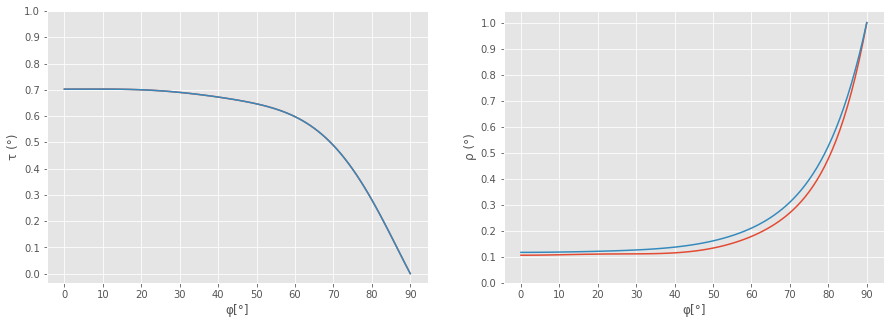

In [4]:
glass_result = np.zeros((5,91))
gl_in = glass_input(0.703, 0.703, 0.106, 0.117, 1, 0, 1)
for j in range(0, 91):
    phi = j
    glass_result[0][j] = phi
    glass_result[1][j] = glass_TRSf(gl_in, phi)
    glass_result[2][j] = glass_TRSb(gl_in, phi)
    glass_result[3][j] = glass_REFf(gl_in, phi)
    glass_result[4][j] = glass_REFb(gl_in, phi)
   
#np.savetxt('glass_result.csv', np.transpose(glass_result), fmt='%.10f', delimiter=',')

#グラフの描画
graph_num = 2
ax = np.empty(graph_num, dtype = np.object)
fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
plt.style.use('ggplot')

gpc = ['C0', 'C1']
gxd = [[glass_result[0][0:91], glass_result[0][0:91]], [glass_result[0][0:91], glass_result[0][0:91]]]
gyd = [[glass_result[1][0:91], glass_result[2][0:91]], [glass_result[3][0:91], glass_result[4][0:91]]]
gxl = 'φ[°]'
gyl = ['τ (°)', 'ρ (°)']
gxt = [10 * i for i in range(10)]
gyt = [0.1 * i for i in range(11)]
    
for i in range(graph_num):   
    ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
    for j in range(2):
        ax[i].plot(gxd[i][j], gyd[i][j], color = gpc[j])
    ax[i].set_xticks(gxt)
    ax[i].set_yticks(gyt)
    ax[i].set_xlabel(gxl, fontsize = 12)
    ax[i].set_ylabel(gyl[i], fontsize = 12)

plt.show()